In [1]:
!pip install selenium

## 1 . Recuperar los textos seleccionados de la pagina

Seleccionamos la primera novela de la trilogia de los juegos del hambre para la tarea, lo cual podemos obtener de la pagina [novelstoday](https://novelstoday.com/the-hunger-games.html). Recuperamos el texto de los capitulos mediante selenium y BeautifulSoup.

In [2]:
# Abrir driver
from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--incognito')
## cambiar el path del driver
path_driver = '/home/anthony/Documentos/Diplomado/NLP for sentimal analysis/chromedriver_linux64/chromedriver'
driver = webdriver.Chrome(path_driver,
                          chrome_options = options)

/home/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: use options instead of chrome_options
  


In [3]:
## Iniciamos la pagina en el primer capitulo
page_url = 'https://novelstoday.com/the-hunger-games/chapter-one.html'
import time
driver.get(page_url)
time.sleep(5)

In [4]:
## Obtener texto de los capitulos 
from bs4 import BeautifulSoup

chapters_text = []
## Recorrer capitulos y extraer el texto
while(True):
    ## html de la pagina
    page_source = driver.page_source
    soup = BeautifulSoup(page_source, 'html.parser')
    # extramos el texto
    chapter_text = soup.find('div', class_='chapterContent ls-15').text
    chapters_text.append(chapter_text)
    ## obtenemos el grupo de botones de paginacion
    control_group = driver.find_element_by_class_name('control-group')
    # obtenemos el boton de siguiente capitulo
    next_chapter = control_group.find_elements_by_tag_name('a')[2]
    # pasamos al siguiente capitulo si no esta desabilitado
    if 'disable' in next_chapter.get_attribute('class'):
        break
    else:
        next_chapter.click()
        time.sleep(3)
        
print(f"Total de capitulos: {len(chapters_text)}")

Total de capitulos: 27


### Guardamos los datos

In [5]:
import pandas as pd
data = [{ 'num_chapter': index + 1 ,'content': chapter } for index ,chapter in enumerate(chapters_text)]
df_data = pd.DataFrame(data)
df_data.to_csv('hunger_games_chapters.csv',index= False)

In [6]:
## Load data
df_data = pd.read_csv('hunger_games_chapters.csv')
df_data.head()

,content,num_chapter
0,"\nPART I ""THE TRIBUTES"" 1. When I wake up, the...",1
1,"2 One time, when I was in a blind in a tree, ...",2
2,"\n3 The moment the anthem ends, we are taken i...",3
3,"\n4 For a few moments, Peeta and I take in the...",4
4,"\n5 R-i-i-i-p! I grit my teeth as Venia, a wom...",5


## 2. Limpieza de datos

Con el objetivo de identificar el tamaño del vocabulario y los términos relevantes con más frecuentes en la lista de Tokens. Se tomo los siguientes puntos para la limpieza de datos del texto extraido en ideoma ingles:

*   Normalizar a minusculas el texto para evitar la duplicacion de tokens en el vocabulario.
*   Expandir las contraciones en el texto para evitar generar palabras extrañas o cambiar el significado al remover la comilla simple por ejemplo : don't -> dont o we're -> were
*   Remover los signos de puntuacion, ya que no aportan al vocabulario y podria generar tokens extraños.
*   Remover las palabras vacias (stopwords), ya que son muy frecuentes y carecen de un significado relevante.
*   Remover las palabras con longitud menor a 3, ya que en el ideoma ingles posiblemente son palabras que no enriquecen el vocabulario.
* Se considera que no es necesario eliminar los caractares no alfanumericos ya que al ser un texto literario ya debe haber pasado por revisiones y no deberia contener caracteres extraños.

In [7]:
## funcion para remover signos de puntuacion
import string
def remove_punctuation(sentence):
    return sentence.translate(str.maketrans("","",string.punctuation))

In [8]:
## cargar stopwords en ingles
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['must','could','would'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anthony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
## Libreria para expandir las contracciones
!pip install contractions

### Limpiar el texto

In [10]:
from nltk import word_tokenize
import contractions

chapters_text = df_data['content']
chapters_clean = []
for chapter in chapters_text:
    # normalizar a minusculas
    chapter_clean = chapter.lower()
    # expandimos la contracciones
    chapter_clean = contractions.fix(chapter_clean)
    # remover punctuacion
    chapter_clean = remove_punctuation(chapter_clean)
    # tokenizar
    tokens_chapter = word_tokenize(chapter_clean)
    # remover stopwords
    tokens_chapter = [word for word in tokens_chapter if word not in stop_words]
    # remover plabras menores a 3 caracteres
    tokens_chapter = [word for word in tokens_chapter if len(word) > 2]
    chapters_clean.append(' '.join(tokens_chapter))

In [11]:
df_data['clean_chapter'] = chapters_clean
df_data.head()

,content,num_chapter,clean_chapter
0,"\nPART I ""THE TRIBUTES"" 1. When I wake up, the...",1,part tributes wake side bed cold fingers stret...
1,"2 One time, when I was in a blind in a tree, ...",2,one time blind tree waiting motionless game wa...
2,"\n3 The moment the anthem ends, we are taken i...",3,moment anthem ends taken custody mean handcuff...
3,"\n4 For a few moments, Peeta and I take in the...",4,moments peeta take scene mentor trying rise sl...
4,"\n5 R-i-i-i-p! I grit my teeth as Venia, a wom...",5,riiip grit teeth venia woman aqua hair gold ta...


## Identificar tamaño de vocabulario y tokens

In [12]:
all_chapters = ' '.join(chapters_clean)

In [13]:
tokens = word_tokenize(all_chapters)
num_tokens = len(tokens)
vocabulary_size = len(set(tokens))
print(f'Numero de tokens: {num_tokens}')
print(f'tamaño de vocabulario: {vocabulary_size}')

Numero de tokens: 45761
tamaño de vocabulario: 7457


In [14]:
tokens = word_tokenize(all_chapters)
num_tokens = len(tokens)
vocabulary_size = len(set(tokens))
print(f'Numero de tokens: {num_tokens}')
print(f'tamaño de vocabulario: {vocabulary_size}')

Numero de tokens: 45761
tamaño de vocabulario: 7457


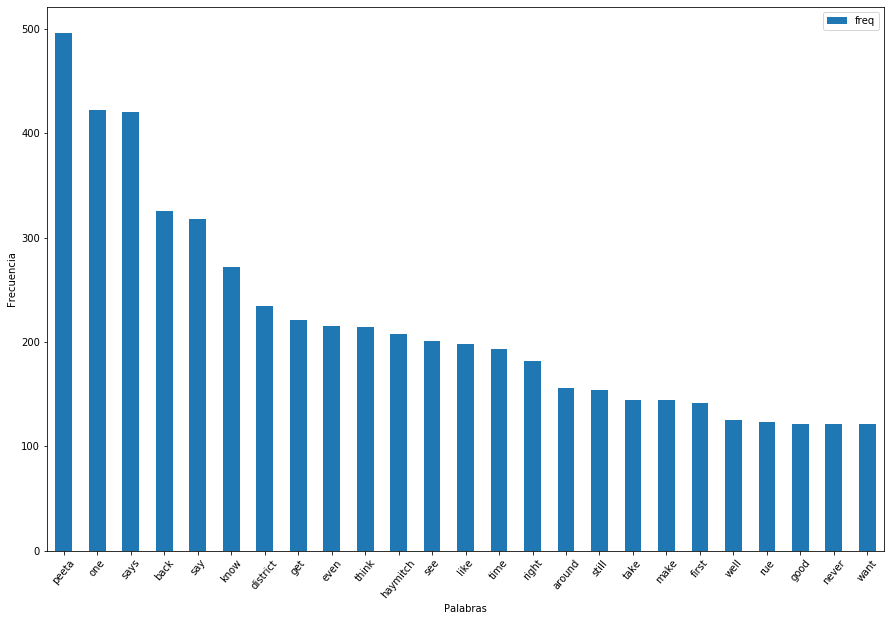

In [15]:
from nltk import FreqDist
import matplotlib.pyplot as plt
%matplotlib inline

## palabras(tokens) mas frecuentes
freq = FreqDist(tokens)
words_frequency = freq.most_common(25)

pd.DataFrame(words_frequency,columns=['word','freq']).set_index('word').plot.bar(figsize = (15,10))
plt.xticks(rotation=50)
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.show()

## 3. Aplicar Stemming
Aplicamos el stemming al prepocesamiento del texto

In [16]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer

ps = PorterStemmer()
chapters_clean = []
for chapter in chapters_text:
    # normalizar a minusculas
    chapter_clean = chapter.lower()
    # expandimos la contracciones
    chapter_clean = contractions.fix(chapter_clean)
    # remover punctuacion
    chapter_clean = remove_punctuation(chapter_clean)
    # tokenizar
    tokens_chapter = word_tokenize(chapter_clean)
    # remover stopwords
    tokens_chapter = [word for word in tokens_chapter if word not in stop_words]
    # remover plabras menor a 3
    tokens_chapter = [word for word in tokens_chapter if len(word) > 2]
    ## aplicar stemming
    tokens_chapter = [ps.stem(word) for word in tokens_chapter ]
    chapters_clean.append(' '.join(tokens_chapter))

In [17]:
df_data['clean_chapter_stemming'] = chapters_clean
df_data.head()

,content,num_chapter,clean_chapter,clean_chapter_stemming
0,"\nPART I ""THE TRIBUTES"" 1. When I wake up, the...",1,part tributes wake side bed cold fingers stret...,part tribut wake side bed cold finger stretch ...
1,"2 One time, when I was in a blind in a tree, ...",2,one time blind tree waiting motionless game wa...,one time blind tree wait motionless game wande...
2,"\n3 The moment the anthem ends, we are taken i...",3,moment anthem ends taken custody mean handcuff...,moment anthem end taken custodi mean handcuf a...
3,"\n4 For a few moments, Peeta and I take in the...",4,moments peeta take scene mentor trying rise sl...,moment peeta take scene mentor tri rise slippe...
4,"\n5 R-i-i-i-p! I grit my teeth as Venia, a wom...",5,riiip grit teeth venia woman aqua hair gold ta...,riiip grit teeth venia woman aqua hair gold ta...


In [18]:
## Identificamos el vocabulario y tokens
all_chapters = ' '.join(chapters_clean)
tokens = word_tokenize(all_chapters)
num_tokens_with_stemming = len(tokens)
vocabulary_size_with_stemming = len(set(tokens))
print(f'Numero de tokens: {num_tokens_with_stemming}')
print(f'tamaño de vocabulario: {vocabulary_size_with_stemming}')

Numero de tokens: 45761
tamaño de vocabulario: 4811


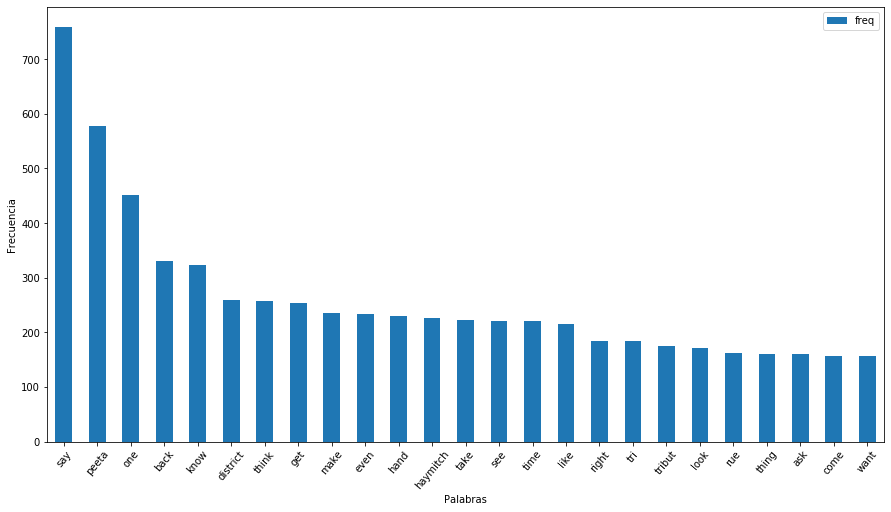

In [19]:
from nltk import FreqDist
## palabras(tokens) mas frecuentes
freq = FreqDist(tokens)
words_frequency_stemming = freq.most_common(25)
pd.DataFrame(words_frequency_stemming,columns=['word','freq']).set_index('word').plot.bar(figsize = (15,8))
plt.xticks(rotation=50)
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.show()

Al aplicar stemming (Porter) el tamaño del vocabulario se redujo considerablemete de $7457$ a $4811$ , ademas las frecuencia de los tokens cambio siendo por ejemplo ahora la palabra $say$ la mas frecuente ya que esta es la forma truncada que represente ahora a varias palabras que tiene esta raiz.